In [ ]:
'''
7.2：为监督指令微调准备数据集

开发用于聊天机器人、个人助理和其他对话任务的 LLM
'''
# Downloading the dataset
import json

file_path = "instruction-data.json"
with open(file_path, "r") as file:
        data = json.load(file)
print("Number of entries:", len(data))

#A 如果文件已经下载，就跳过下载过程



In [7]:
# Alpaca 提示词风格 vs Phi-3 提示词风格

# 定义一个format_input函数，用于将数据列表中的条目转换为 Alpaca 风格输入格式
# Implementing the prompt formatting function
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
# Partitioning the dataset 划分数据集
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.1) # 10% for testing
val_portion = len(data) - train_portion - test_portion # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [9]:
'''
7.3: 将数据组织成训练批次
'''

# Implementing an instruction dataset class
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:                                           #A
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

#A 预分词文本

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
'''
通过仅将序列扩展到每个批次中最长的序列长度，从而减少了不必要的填充，避免了对整个数据集进行冗余填充
'''

def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [11]:
# 在三个不同输入上进行测试，目标是将它们合并为一个批次，并对每个样本进行填充以保证长度一致
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [12]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])             #A
        targets = torch.tensor(padded[1:])             #B
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


#A 截断输入序列的最后一个 token。
#B 将目标序列中的每个 token 向右移动一个位置。

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [15]:
# 接下来，我们会将所有填充 token 设置为占位值 -100。这个特殊值可以让填充 token 不参与训练损失的计算，从而确保只有有效数据会影响模型的学习
# 请注意，我们在目标列表中仍保留了一个文本结束 token（ID 为 50256），这使得 LLM 能够学习在接收到指令时何时生成结束 token，以指示生成的响应已完成

'''
修改了自定义的 collate 函数，将目标列表中 ID 为 50256 的 token 替换为 -100
引入了一个 allowed_max_length 参数，用于选择性地限制样本的长度
'''
# Implementing a custom batch collate function
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets

        mask = targets == pad_token_id                  #A
        indices = torch.nonzero(mask).squeeze()         #A
        print(indices)
        if indices.numel() > 1:                         #A
            targets[indices[1:]] = ignore_index         #A

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]        #B
            targets = targets[:allowed_max_length]      #B

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst)
    return inputs_tensor, targets_tensor


#A 在 targets 中，将除第一个以外的所有填充标记替换为 ignore_index
#B 可选择性地将序列截断到最大长度

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor(4)
tensor([1, 2, 3, 4])
tensor([2, 3, 4])
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
'''
修改后的custom_collate_fn函数按预期工作，通过插入 token ID -100 来改变目标列表

但是这种调整背后的逻辑是什么呢？
'''

logits_1 = torch.tensor(
    [[-1.0, 1.0], # predictions for 1st token
     [-0.5, 1.5]] # predictions for 2nd token
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]                        #A
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

#A 添加第三个 token ID

tensor(1.1269)
tensor(0.7936)


In [19]:
# 如果我们将第三个目标 token ID 替换为 -100，会发生什么
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [22]:
'''
可以看到，交叉熵损失函数忽略了 targets_3 向量中的第三个条目，即对应 token ID 为 -100 的位置
这是因为在 PyTorch 中，cross_entropy 函数的默认设置是 cross_entropy(..., ignore_index=-100)，这意味着它会忽略标签为 -100 的目标。

同时，通过对指令部分对应的目标 token ID 进行掩码，交叉熵损失仅计算生成响应的目标 token ID，模型在训练时也会专注于生成准确的回答，而不是去记住指令内容，从而有助于减少过拟合。
但对于在指令微调过程中遮蔽指令是否具有普遍效果存在分歧
'''

'''
7.4: 为指令数据集创建数据加载器
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():       #A
#     device = torch.device("mps")"           #A
print("Device:", device)

#A 取消这两行注释以在 Apple Silicon 芯片上启用 GPU

# 将 custom_collate_fn 函数传入 PyTorch 的 DataLoader 类时复用device参数设置
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)


# 接下来用自定义的collate函数来处理批次数据
# Initializing the data loaders
from torch.utils.data import DataLoader

num_workers = 0            #A
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

#A 如果操作系统支持并行的 Python 进程，你可以尝试增加此数值。

Device: cpu


In [23]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
tensor(60)
tensor([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
torch.Size([8, 61]) torch.Size([8, 61])
tensor([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor(75)
tensor([53, 54, 55, 56, 57, 58, 

In [25]:
# 得益于自定义的collate函数，通过上述数据加载器，可以创建包含不同长度数据的批次
'''
7.5: 加载预训练的LLM

1.24 亿参数的小模型容量有限，难以通过指令微调获得令人满意的效果
下载中等规模的 GPT 模型，该模型的存储需求约为 1.42 GB，约是小型模型所需存储空间的三倍
'''

from ch_5.gpt_download import download_and_load_gpt2
from ch_4.build_gpt import GPTModel
from ch_5.ch5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()



Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])
tensor(-10.5722)
tensor(10.5722)
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.5722)
Characters: 20479
Tokens: 5145
Training loss: 10.987583584255642
Validation loss: 10.981106758117676
Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 647kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 22.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [53:33<00:00, 442kiB/s]    
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 10.7MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 15.0MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 10.3MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [34]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [44]:
from ch_5.ch5 import text_to_token_ids, token_ids_to_text
from ch_5.generate_script import generate

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

# 为了提取模型的响应文本，我们需要从生成的文本起始部分减去输入指令的长度
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

Write an offline HTML response template that identifies the consumer: This is a popular web target: e.g. }Halt and pause pending response at: What resource


In [45]:
'''
7.6:  指令微调 LLM
'''

from ch_5.ch5 import calc_loss_loader, train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

tensor(60)
tensor([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
tensor(75)
tensor([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
      

In [46]:
# Instruction finetuning the pretrained LLM
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

tensor(60)
tensor([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([57, 58, 59, 60])
tensor([54, 55, 56, 57, 58, 59, 60])
tensor([55, 56, 57, 58, 59, 60])
tensor([58, 59, 60])
tensor([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor(60)
tensor([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])
tensor(56)
tensor([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])
tensor([52, 53, 54, 55, 56])
tensor([53, 54, 55, 56])
tensor([47, 48, 49, 50, 51, 52, 53, 54, 55, 56])
tensor([51, 52, 53, 54, 55, 56])
tensor([50, 51, 52, 53, 54, 55, 56])
tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
tensor([5

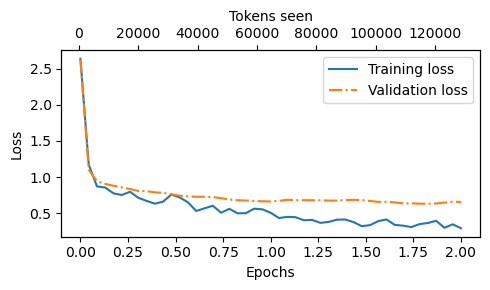

In [47]:
from ch_5.ch5 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [48]:
'''
7.7: 提取并保存响应
'''

torch.manual_seed(123)
for entry in test_data[:3]:                #A
    input_text = format_input(entry)
    token_ids = generate(                  #B
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:",
"").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


#A 遍历测试集中的前三个样本
#B 使用在第 7.5 节导入的 generate 函数

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a situation where a harsh, windy, humid, or freezing sky tends to form a thundercloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model respo

In [49]:
# Generating test set responses
# 将生成的模型响应追加到 test_set 字典中，并将更新后的数据保存为名为 instruction-data-with-response.json 的文件以便记录
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:",
"").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4) # "indent" for pretty-printing

100%|██████████| 110/110 [10:15<00:00,  5.60s/it]


In [51]:
print(test_data[0])

# 我们将模型保存为文件
import re

# Remove white spaces and parentheses from file name
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a snail.'}
Model saved as gpt2-medium355M-sft.pth


In [52]:
'''
7.8: 评估指令微调后的 LLM

利用另一个更大的大语言模型对微调模型的响应进行自动化评估
'''
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [58]:
# 通过REST API替代ollama run
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

#
# model = "llama3"
# result = query_model("What do Llamas eat?", model)
# print(result)

HTTPError: HTTP Error 500: Internal Server Error

In [75]:
from openai import OpenAI
import os

os.environ['NO_PROXY'] = 'api.openai.rnd.huawei.com'
client = OpenAI(
    base_url='http://api.openai.rnd.huawei.com/v1',
    api_key='sk-1234',
)

# 列出所有模型
models = client.models.list().data
for m in models:
    print(m)

def query_model_response(prompt, model):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {'role': 'system', 'content': 'You are a very helpful, respectful and honest assistant.'},
            {'role': 'user', 'content': prompt},
        ],
        temperature=0.3,
        stream=False,
    )
    return response.choices[0].message.content

model_name = "deepseek-chat"
result = query_model("What do Llamas eat? List them with number and explain.", model_name)
print(result)

Model(id='qwen2.5-coder-32b-instruct', created=1677610602, object='model', owned_by='openai')
Model(id='qwq-32b-128k', created=1677610602, object='model', owned_by='openai')
Model(id='qwen2.5-coder-7b-instruct', created=1677610602, object='model', owned_by='openai')
Model(id='qwen2.5-vl-32b-instruct', created=1677610602, object='model', owned_by='openai')
Model(id='qwen2.5-32b-instruct-vllm', created=1677610602, object='model', owned_by='openai')
Model(id='nomic-embed-text', created=1677610602, object='model', owned_by='openai')
Model(id='bge-large', created=1677610602, object='model', owned_by='openai')
Model(id='qwen2-vl-72b-instruct', created=1677610602, object='model', owned_by='openai')
Model(id='internvl2.5-26b', created=1677610602, object='model', owned_by='openai')
Model(id='bge-m3', created=1677610602, object='model', owned_by='openai')
Model(id='gemma-3-27b-it', created=1677610602, object='model', owned_by='openai')
Model(id='qwen2.5-32b-instruct', created=1677610602, object=

In [76]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model_response(prompt, model_name))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a snail.

Score:
>> The model response "The car is as fast as a snail." is a valid simile, but it contradicts the original meaning of the sentence ("The car is very fast"). Here's the scoring breakdown:

- **Creativity/Form (Simile Structure)**: 50/100  
  (The sentence is correctly structured as a simile, but the comparison is opposite to the intended meaning.)
  
- **Accuracy/Meaning**: 0/100  
  (The simile inverts the original meaning, making it inaccurate.)
  
- **Overall Score**: 25/100  
  (While the response technically fulfills the instruction of creating a simile, it fails to preserve the original sentiment, resulting in a low score.)  

A better response would maintain the idea of speed, like the correct output: "The car is as fast as lightning." (which would score 100/100).

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms

In [71]:
'''
generate_model_scores 函数使用了一个修改后的prompt，要求模型‘仅回复整数’, 可以计算模型的平均分
'''

#  Evaluating the instruction finetuning LLM
def generate_model_scores(json_data, json_key, model="deepseek-chat"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."                        #A
        )
        score = query_model_response(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

#A 修改后的指令设置为仅返回分数。

# Let's now apply the generate_model_scores function to the entire test_data set
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  74%|███████▎  | 81/110 [06:15<02:39,  5.51s/it]

Could not convert score: 10 

(The response is largely incorrect and nonsensical, failing to address the instruction properly. It introduces unrelated and confusing information, earning a very low score.)


Scoring entries: 100%|██████████| 110/110 [08:33<00:00,  4.67s/it]

Number of scores: 109 of 110
Average score: 41.24

